# PATH ridership over time

Cleaned + Plotted Port Authority data from https://www.panynj.gov/path/en/about/stats.html

In [1]:
from utz import *
from utz.colors import colors_lengthen
from datetime import timedelta
from ire import export
from path_data.paths import DATA, ALL_PQT

Papermill parameters:

In [2]:
force = True
default_show = 'png'
W = 1200
H = 600
end_month = None

In [3]:
rename_stations = {
    '9thStreet': '9th Street',
    '14thStreet': '14th Street',
    '23rdStreet': '23rd Street',
    '33rdStreet': '33rd Street',
    'Pavonia/ Newport': 'Newport',
}

In [4]:
df = concat([
    read_parquet(pqt_path)
    for pqt_path in sorted(glob.glob(f'{DATA}/2*.pqt'))
    if fullmatch(r'\d{4}\.pqt', basename(pqt_path))
]).reset_index()
stations = df.station.apply(lambda s: rename_stations.get(s, s))
df['station'] = stations
df = df[~df.station.str.contains('TOTAL')].copy()
df['dt'] = to_dt(df.month)
df['year'] = df.dt.dt.year
df['month_idx'] = df.dt.dt.month
df

,month,station,avg daily,avg weekday,avg sat,avg sun,avg holiday,total,total weekday,total sat,total sun,total holiday,dt,year,month_idx
0,2012-01-01,Christopher Street,3619,4256,2708,2433,2040,112187,85113,10830,12163,4081,2012-01-01,2012,1
1,2012-01-01,9th Street,4087,4483,3695,3436,2533,126682,89658,14780,17178,5066,2012-01-01,2012,1
2,2012-01-01,14th Street,7370,8768,5346,4730,4041,228483,175369,21384,23648,8082,2012-01-01,2012,1
3,2012-01-01,23rd Street,6374,8345,2924,2563,3096,197597,166895,11698,12813,6191,2012-01-01,2012,1
4,2012-01-01,33rd Street,28586,34797,17350,16716,18627,886167,695937,69398,83578,37254,2012-01-01,2012,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2611,2024-10-01,Journal Square,22312,25266,16775,12453,18928,691683,555843,67100,49812,18928,2024-10-01,2024,10
2612,2024-10-01,Grove Street,15709,17807,12320,8525,11836,486966,391748,49281,34101,11836,2024-10-01,2024,10
2613,2024-10-01,Exchange Place,10880,12656,7053,5530,8524,337289,278436,28211,22118,8524,2024-10-01,2024,10
2614,2024-10-01,Newport,11445,13629,6450,4752,10137,354786,299843,25798,19008,10137,2024-10-01,2024,10


In [5]:
dfs = []
for pqt_path in sorted(glob.glob(f'{DATA}/2*-day-types.pqt')):
    year = fullmatch(r'(?P<y>\d{4})-day-types\.pqt', basename(pqt_path))['y']
    dfs.append(read_parquet(pqt_path).assign(year=int(year)))
day_hists = pd.concat(dfs).reset_index().set_index(['year', 'month'])
day_hists

weekdays  saturdays  sundays  holidays
year month                                        
2012 1            20          4        5         2
     2            20          4        4         1
     3            22          5        4         0
     4            21          4        5         0
     5            22          4        4         1
...              ...        ...      ...       ...
2024 6            19          5        5         1
     7            22          4        4         1
     8            22          5        4         0
     9            20          4        5         1
     10           22          4        4         1

[154 rows x 4 columns]

In [6]:
m = (
    df.merge(
        day_hists,
        how='left',
        left_on=['year', 'month_idx'],
        right_index=True,
    )
    .rename(columns={
        'saturdays': 'sats',
        'sundays': 'suns',
    })
    .drop(columns=['year', 'month_idx', 'dt', 'avg daily', 'total'])
)

for k in ['weekday', 'sat', 'sun', 'holiday']:
    tk = f'total {k}'
    ak = f'avg {k}'
    nk = f'{k}s'
    avg = m[tk] / m[nk]
    mask = (abs(avg - m[ak]) < .51) | ((m[nk] == 0) & (m[tk] == 0))
    if not all(mask):
        err(k)
        raise ValueError(m.loc[~mask, [tk, nk, ak]])
    m[ak] = avg

m['weekends'] = m.sats + m.suns
m['total weekend'] = m['total sat'] + m['total sun']
m['avg weekend'] = m['total weekend'] / m['weekends']

cols = ['month', 'station'] + [
    p+k+s
    for p, s in [('total ', ''), ('avg ', ''), ('', 's')]
    for k in ['weekday', 'weekend', 'sat', 'sun', 'holiday']
]
cols += [ c for c in m if c not in cols ]
m = m[cols]
m['month'] = m.month.astype('datetime64[s]')
m

,month,station,total weekday,total weekend,total sat,total sun,total holiday,avg weekday,avg weekend,avg sat,avg sun,avg holiday,weekdays,weekends,sats,suns,holidays
0,2012-01-01,Christopher Street,85113,22993,10830,12163,4081,4255.650000,2554.777778,2707.50,2432.60,2040.5,20,9,4,5,2
1,2012-01-01,9th Street,89658,31958,14780,17178,5066,4482.900000,3550.888889,3695.00,3435.60,2533.0,20,9,4,5,2
2,2012-01-01,14th Street,175369,45032,21384,23648,8082,8768.450000,5003.555556,5346.00,4729.60,4041.0,20,9,4,5,2
3,2012-01-01,23rd Street,166895,24511,11698,12813,6191,8344.750000,2723.444444,2924.50,2562.60,3095.5,20,9,4,5,2
4,2012-01-01,33rd Street,695937,152976,69398,83578,37254,34796.850000,16997.333333,17349.50,16715.60,18627.0,20,9,4,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2611,2024-10-01,Journal Square,555843,116912,67100,49812,18928,25265.590909,14614.000000,16775.00,12453.00,18928.0,22,8,4,4,1
2612,2024-10-01,Grove Street,391748,83382,49281,34101,11836,17806.727273,10422.750000,12320.25,8525.25,11836.0,22,8,4,4,1
2613,2024-10-01,Exchange Place,278436,50329,28211,22118,8524,12656.181818,6291.125000,7052.75,5529.50,8524.0,22,8,4,4,1
2614,2024-10-01,Newport,299843,44806,25798,19008,10137,13629.227273,5600.750000,6449.50,4752.00,10137.0,22,8,4,4,1


In [7]:
m.dtypes

month            datetime64[s]
station                 object
total weekday            int64
total weekend            int64
total sat                int64
total sun                int64
total holiday            int64
avg weekday            float64
avg weekend            float64
avg sat                float64
avg sun                float64
avg holiday            float64
weekdays                 int64
weekends                 int64
sats                     int64
suns                     int64
holidays                 int64
dtype: object

In [8]:
if force or not exists(ALL_PQT):
    m.to_parquet(ALL_PQT, index=False)

In [9]:
station_hist = stations.value_counts()
station_hist

station
Christopher Street     154
Harrison               154
NEW JERSEY SUBTOTAL    154
Hoboken                154
Newport                154
Exchange Place         154
Grove Street           154
Journal Square         154
Newark                 154
9th Street             154
NEW YORK SUBTOTAL      154
WTC                    154
UPTOWN SUBTOTAL        154
33rd Street            154
23rd Street            154
14th Street            154
MONTHLY TOTAL          154
Name: count, dtype: int64

In [10]:
assert len(station_hist.value_counts()) == 1

In [11]:
if not default_show:
    default_show = None

if end_month is None:
    end_month = (df.month.max() + pd.Timedelta('32d')).strftime('%Y-%m')
end_month

'2024-11'

In [12]:
mt = m.drop(columns='station').groupby('month').sum()
month_dt = to_dt(mt.index.to_series())
months = month_dt.dt
month_idxs = months.month.rename('month_idx')
years = months.year.rename('year')
mt = sxs(years, month_idxs, mt)
mt

,year,month_idx,total weekday,total weekend,total sat,total sun,total holiday,avg weekday,avg weekend,avg sat,avg sun,avg holiday,weekdays,weekends,sats,suns,holidays
month,,,,,,,,,,,,,,,,,
2012-01-01,2012,1,5055387,859750,428830,430920,213096,252769.350000,95527.777778,107207.50,86184.00,106548.0,260,117,52,65,26
2012-02-01,2012,2,5229454,805942,459565,346377,116023,261472.700000,100742.750000,114891.25,86594.25,116023.0,260,104,52,52,13
2012-03-01,2012,3,5935471,1017669,649878,367791,0,269794.136364,113074.333333,129975.60,91947.75,0.0,286,117,65,52,0
2012-04-01,2012,4,5474674,970803,529898,440905,0,260698.761905,107867.000000,132474.50,88181.00,0.0,273,117,52,65,0
2012-05-01,2012,5,5747143,915369,517147,398222,91973,261233.772727,114421.125000,129286.75,99555.50,91973.0,286,104,52,52,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-01,2024,6,3670100,970478,554072,416406,131338,193163.157895,97047.800000,110814.40,83281.20,131338.0,247,130,65,65,13
2024-07-01,2024,7,4032554,731427,419562,311865,117619,183297.909091,91428.375000,104890.50,77966.25,117619.0,286,104,52,52,13
2024-08-01,2024,8,3865000,810081,517355,292726,0,175681.818182,90009.000000,103471.00,73181.50,0.0,286,117,65,52,0


In [13]:
from calendar import month_abbr
pivoted = (
    mt
    .assign(month=mt.month_idx.apply(lambda m: month_abbr[m]))
    .set_index(['month_idx', 'month'])
    [['year', 'avg weekday', 'avg weekend', 'avg sat', 'avg sun']]
    .pivot(columns='year')
    .replace(nan, 0).astype(int)
    .sort_index()
    .reset_index(level=0, drop=True)
)
pivoted

avg weekday                                                          \
year         2012    2013    2014    2015    2016    2017    2018    2019   
month                                                                       
Jan        252769  217345  231473  227562  250484  266846  266614  272332   
Feb        261472  233633  233110  245224  259236  266277  279693  278047   
Mar        269794  235594  248144  250488  265131  266744  264986  281604   
Apr        260698  248688  252737  258354  270124  289351  284283  285930   
May        261233  249228  255112  264329  271904  284091  291747  289413   
Jun        265072  252261  259001  267051  277946  288215  291075  292315   
Jul        265127  250018  258038  267492  272799  297494  281776  288163   
Aug        256278  245527  250156  259294  269440  296998  275442  281488   
Sep        267479  256737  258150  269041  278139  293421  289128  298519   
Oct        233818  259234  262365  274483  276417  297031  299787  296976   
Nov        121495  252038  253715  268329  277473  291557  287651  290129   
Dec        185834  233063  237435  248434  258947  265518  258220  257958   

                                              avg weekend                  \
year     2020    2021    2022    2023    2024        2012    2013    2014   
month                                                                       
Jan    277233   56903   84185  145635  161765       95527   71793   82017   
Feb    282850   52604  113247  150237  171388      100742   76569   94184   
Mar    126408   64331  132440  155238  177645      113074   99111   92322   
Apr     14596   70156  135338  161954  182180      107867  105665   97936   
May     20444   79652  140301  171363  192651      114421  101889  101516   
Jun     34366   91755  148026  164559  193163      116769  109825  101137   
Jul     47028   99230  138957  162386  183297      109675  101328   95779   
Aug     54123   98422  138503  162576  175681      112315  109007   93827   
Sep     62650  113597  157981  178947  206542      117874  109077   96405   
Oct     65840  124726  158481  185147  211525      114902  109496   95562   
Nov     61753  128093  155525  176612       0       43762   99845   89673   
Dec     55354  112666  139596  160300       0       69253  103426  101366   

                                                                           \
year     2015    2016    2017    2018    2019   2020   2021   2022   2023   
month                                                                       
Jan     78582   77728   86784   85624   73360  74502  30711  42657  69585   
Feb     82078   89792   95271   88136   81987  82704  32741  60742  69142   
Mar     92510  101323   92523  103004   87886  36523  40567  64200  74664   
Apr    106301  104505  107946  103954   96567   6935  44541  74555  77751   
May    107425  101677  101781  100586   97908  10890  50144  71893  89091   
Jun    107011  107583  111427  110271  101675  18901  65780  82836  89449   
Jul    104194  101454  106582   91841   90233  25766  65199  75270  82762   
Aug    107570   87769  107192   88645   98576  30634  59511  77924  86588   
Sep    109970   96232  111447   96500  101704  38916  73652  86047  83802   
Oct    110087   88010  107386   89490   96709  41378  74408  82763  86657   
Nov    102265   91880  101310  100140   93908  35455  73318  80946  84707   
Dec    111703   90492  103127  111745  107069  31694  66333  73964  90568   

              avg sat                                                          \
year     2024    2012    2013    2014    2015    2016    2017    2018    2019   
month                                                                           
Jan     64782  107207   81710   91282   88873   87875   97009  100665   84350   
Feb     75690  114891   83702  109728   94726  102088  110189  101732   94428   
Mar     79578  129975  118285  110695  107723  119979  107588  118684  106133   
Apr     92338  132474  122783  112770  122708  11750

In [14]:
import plotly.express as px
from IPython.display import Image

In [15]:
gridcolor = '#ccc'

def default_plot(fig, hoverformat=','):
    return (
        fig
        .update_layout(
            title_x=0.5,
            paper_bgcolor='white',
            plot_bgcolor='white',
            legend=dict(traceorder='reversed'),
            hovermode='x',
        ).update_xaxes(
            tickangle=-45,
            gridcolor=gridcolor,
        ).update_traces(
            hovertemplate=None,
        ).update_yaxes(
            gridcolor=gridcolor,
            hoverformat=hoverformat,
        )
    )

In [16]:
def stations_stack(
    y, title, name=None,
    start=None, end=None,
    dtick=None, tickangle=-45,
    width=W, height=H,
    show=default_show,
):
    if isinstance(start, str):
        start = to_dt(start)
    start = start or to_dt('2012')
    start -= timedelta(days=15)
    if isinstance(end, str):
        end = to_dt(end)
    end = end or to_dt(end_month)
    end -= timedelta(days=15)
    dims = dict(width=width, height=height)
    fig = default_plot(
        px.bar(
            m.reset_index(),
            x='month', y=y, color='station',
            title=title,
            labels={
                'station': 'Station',
                y: title,
                'month': '',
            }
        )
    ).update_xaxes(
        range=[start, end],
        dtick=dtick,
    ).update_layout(**dims)
    if name:
        path = f'img/{name}.png'
        print(f'Saving {path}')
        fig.write_image(path, **dims)
    return export(fig, name, show=show)

In [17]:
num_years = len(mt.year.unique())
num_years

13

In [18]:
px_colors = px.colors.sequential.Inferno
colors = list(reversed(colors_lengthen(px_colors, num_years)))
colors

['#fcffa4',
 '#f8dc56',
 '#f9b621',
 '#f78e0d',
 '#ed6925',
 '#d64d3d',
 '#ba3853',
 '#992863',
 '#781c6d',
 '#55106b',
 '#320c56',
 '#140931',
 '#000004']

In [19]:
month_names = [ to_dt('2022-%02d' % i).strftime('%b') for i in range(1, 13) ]
print(' '.join(month_names))

Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec


In [20]:
def grouped_month_plot(y, title, width=W, height=H, show=default_show):
    fig = px.bar(
        mt,
        x='month_idx', y=y,
        color=mt.year.astype(str),
        color_discrete_sequence=colors,
        labels={
            'color': 'Year',
            'month_idx': '',
            y: title,
        },
        barmode='group',
    )
    dims = dict(width=width, height=height)
    fig = fig.update_layout(
        title=f'{title} (grouped by month)',
        title_x=0.5,
        xaxis=dict(
            tickmode = 'array',
            tickvals = list(range(1, 13)),
            ticktext = month_names,
        ),
        **dims,
    )
    name = f'{y}_month_grouped.png'
    path = f'img/{name}'
    fig.write_image(path, **dims)
    return export(fig, name, show=show)

# Weekdays

Saving img/weekdays.png


Saved plotly to .ire/weekdays.json


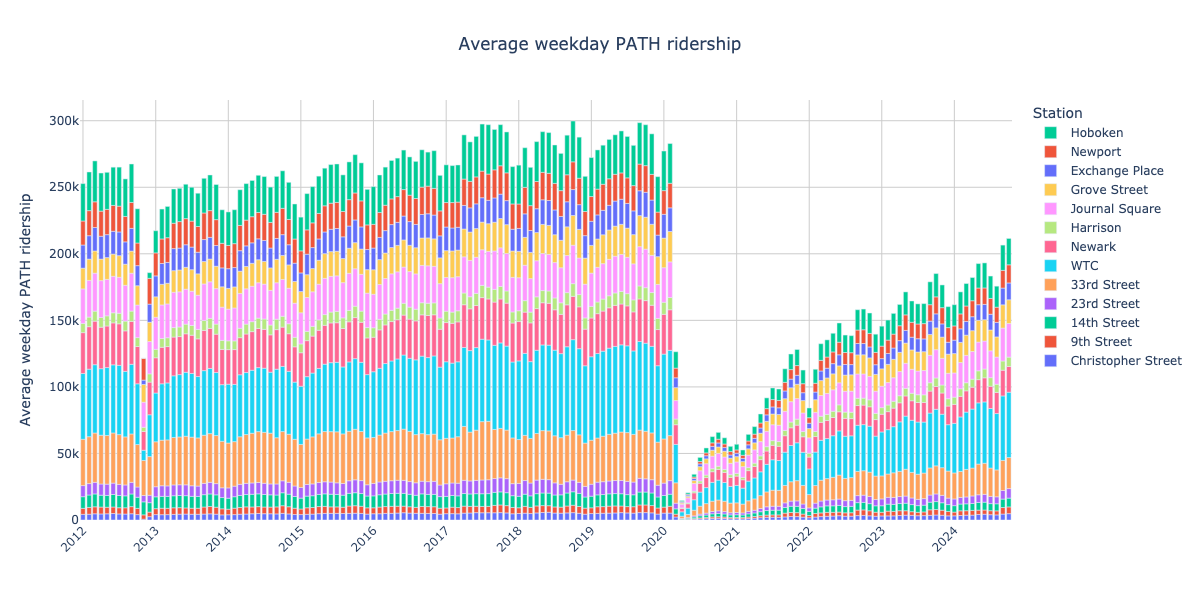

In [21]:
stations_stack(
    'avg weekday',
    'Average weekday PATH ridership',
    dtick="M12",
    name='weekdays',
)

Saving img/weekdays_2020:.png


Saved plotly to .ire/weekdays_2020:.json


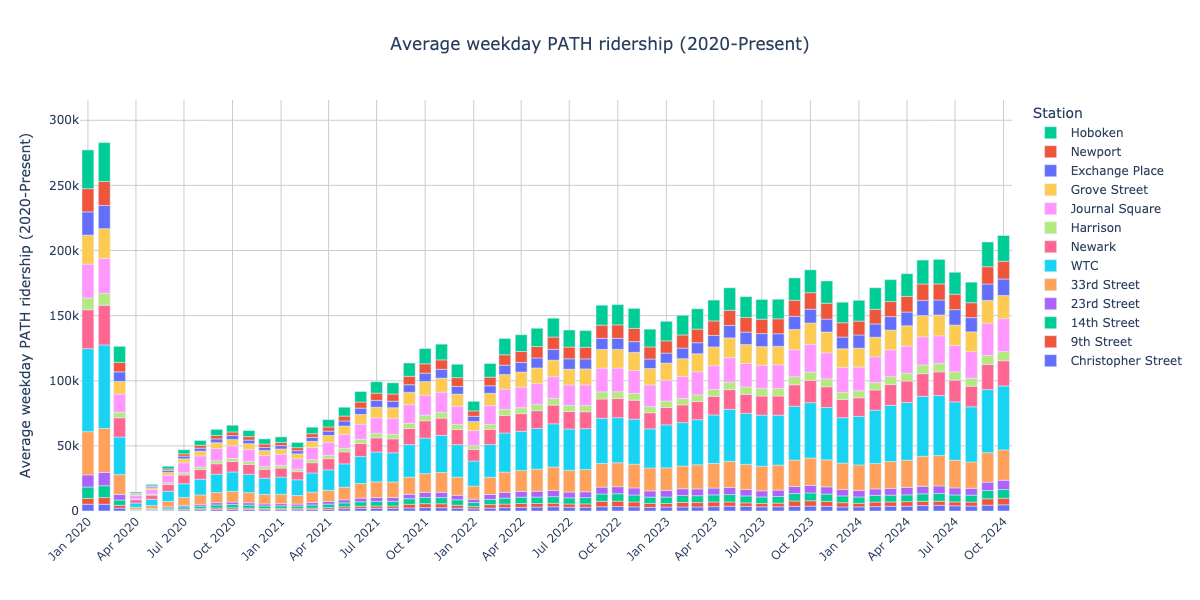

In [22]:
stations_stack(
    'avg weekday',
    'Average weekday PATH ridership (2020-Present)',
    name='weekdays_2020:',
    dtick='M3',
    start='2020',
)

Saved plotly to .ire/avg weekday_month_grouped.png.json


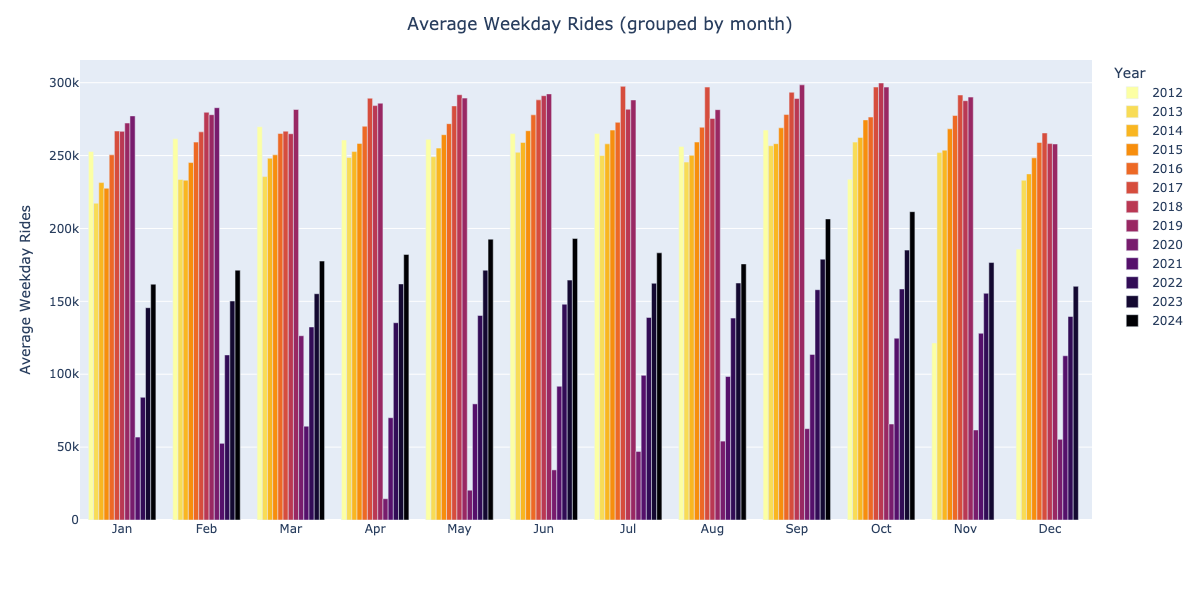

In [23]:
grouped_month_plot('avg weekday', 'Average Weekday Rides')

# Weekends

Saving img/weekends.png


Saved plotly to .ire/weekends.json


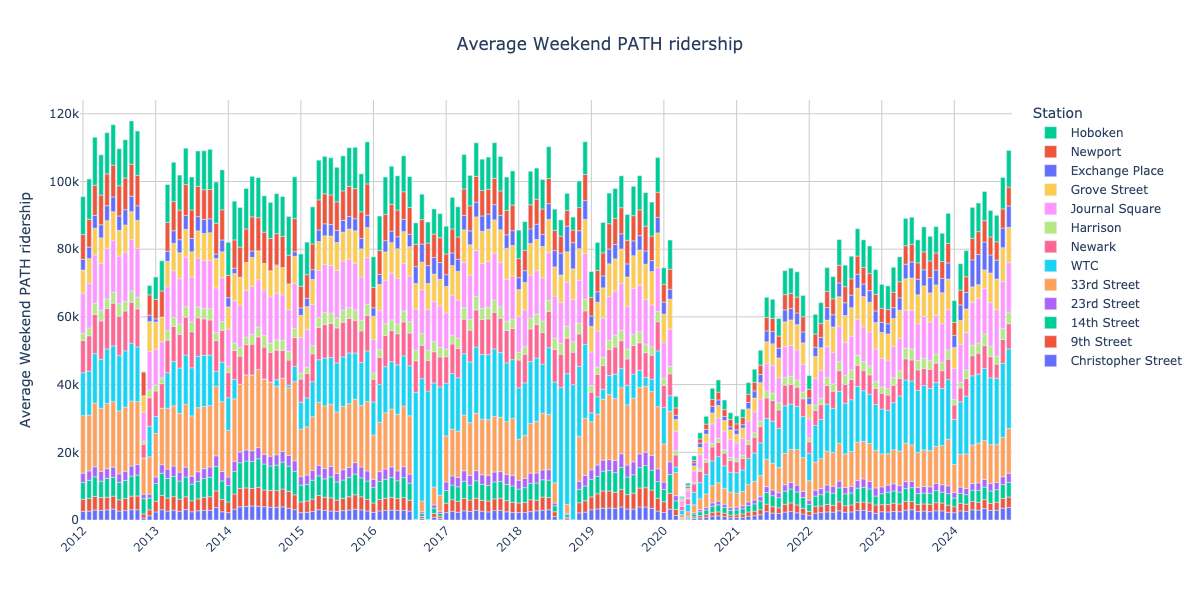

In [24]:
stations_stack(
    'avg weekend',
    'Average Weekend PATH ridership',
    dtick="M12",
    name='weekends',
)

Saving img/weekends_2020:.png


Saved plotly to .ire/weekends_2020:.json


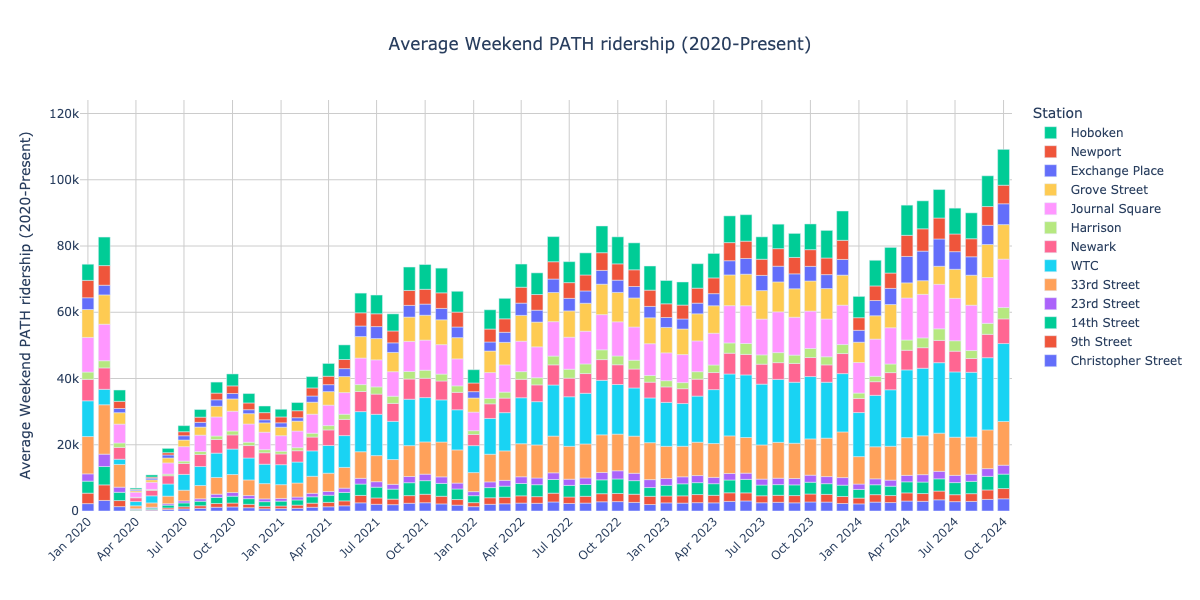

In [25]:
stations_stack(
    'avg weekend',
    'Average Weekend PATH ridership (2020-Present)',
    dtick="M3",
    name='weekends_2020:',
    start='2020',
)

Saved plotly to .ire/avg weekend_month_grouped.png.json


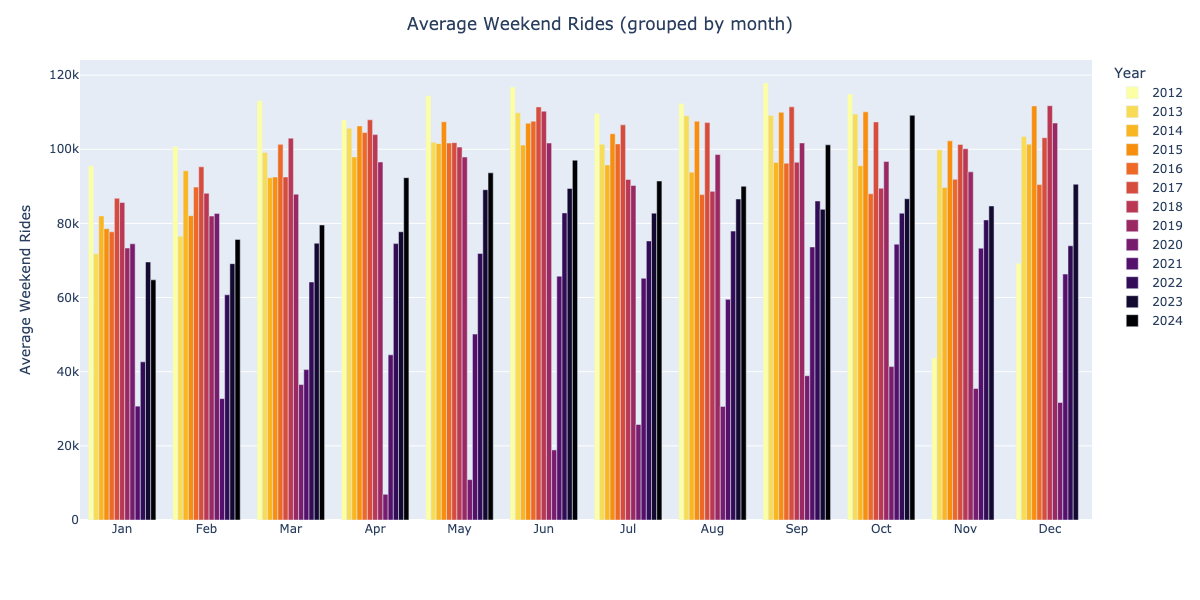

In [26]:
grouped_month_plot('avg weekend', 'Average Weekend Rides')

# Combined

## Average Daily PATH Ridership <a id="avg-daily"></a>

In [27]:
def lines(
    df, name, xname, y_fmt,
    hoverx=True, dir='img',
    legend_lr=False,
    ann_offset=10,
    xtick=None, xtickformat=None,
    ytick=None, ytickformat=None,
    show=default_show,
    w=1000, h=600,
    **kwargs,
):
    fig = px.line(
        df,
        labels={
            'variable': '',
            'value': xname,
            'month': '',
        }
    )
    idx = df.index.to_series()
    for k in df:
        x = idx.iloc[-1]
        y = df[k].iloc[-1]
        x_str = x.strftime("%b '%y")
        y_str = format(y, y_fmt)
        fig.add_annotation(
            x=x,
            ax=idx.iloc[-ann_offset],
            axref="x",
            y=y,
            text=f'{x_str}: {y_str}',
        )
    fig = plots.save(
        fig,
        name=name,
        x=dict(dtick=xtick, tickformat=xtickformat),
        y=dict(dtick=ytick, tickformat=ytickformat),
        legend=(
            dict(
                yanchor="bottom",
                y=0.03,
                xanchor="right",
                x=0.99,
            ) if legend_lr else dict(
                yanchor="top",
                y=0.99,
                xanchor="right",
                x=0.99,
            )
        ),
        hoverx=hoverx,
        dir=dir,
        w=w, h=h,
        **kwargs,
    )
    return export(fig, name, show=show)

Wrote plot JSON to img/avg_day_types.json
Wrote plot image to img/avg_day_types.png
Saved plotly to .ire/avg_day_types.json


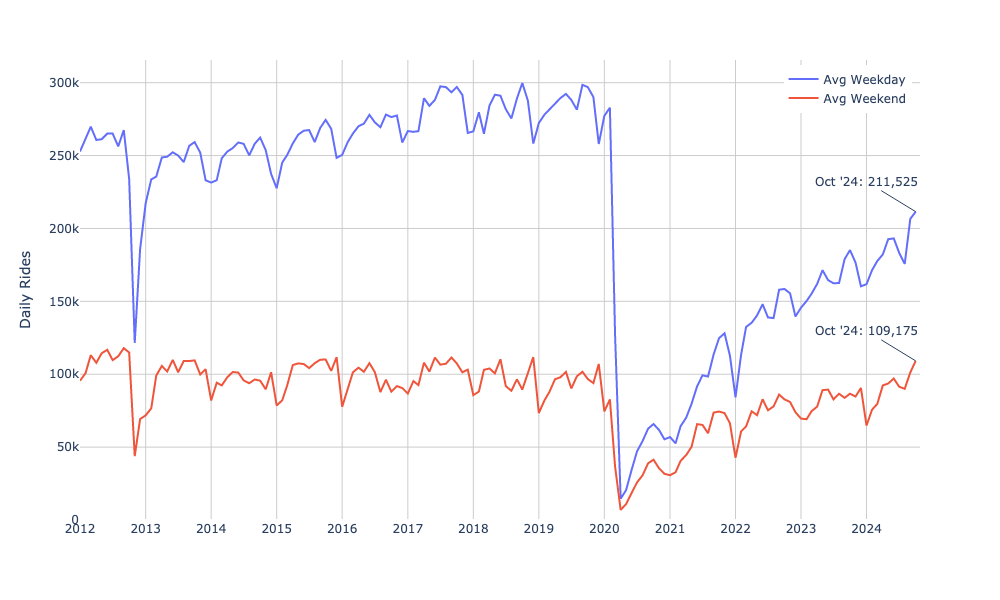

In [28]:
lines(
    mt[['avg weekday', 'avg weekend',]].rename(columns={
        'avg weekday': 'Avg Weekday',
        'avg weekend': 'Avg Weekend',
    }),
    name='avg_day_types',
    xname = 'Daily Rides',
    xtick = "M12",
    hovertemplate='%{y:,.0f}',
    y_fmt = ',.0f',
    legend_lr=False,
)

## 2020-2022 Ridership vs. 2019

In [29]:
mt20 = mt[month_dt >= to_dt('2020')]
mt19 = mt[mt.year == 2019]
mt19s = pd.concat([ mt19 for i in range((len(mt20) + len(mt19) - 1) // len(mt19)) ]).iloc[:len(mt20)]

keys = ['avg weekday', 'avg weekend']
cmp19 = (
    sxs(
        mt19s.reset_index(drop=True)[keys].rename(columns={ key: f'{key} 2019' for key in keys }),
        mt20.reset_index()[keys + ['month']],
    )
    .set_index('month')
)
for k in keys:
    cmp19[f'{k} frac'] = cmp19[k] / cmp19[f'{k} 2019']
cmp19

,avg weekday 2019,avg weekend 2019,avg weekday,avg weekend,avg weekday frac,avg weekend frac
month,,,,,,
2020-01-01,272332.142857,73360.000000,277233.571429,74502.625000,1.017998,1.015576
2020-02-01,278047.157895,81987.375000,282850.210526,82704.000000,1.017274,1.008741
2020-03-01,281604.857143,87886.600000,126408.681818,36523.000000,0.448887,0.415570
2020-04-01,285930.000000,96567.625000,14596.500000,6935.375000,0.051049,0.071819
2020-05-01,289413.181818,97908.125000,20444.700000,10890.800000,0.070642,0.111235
2020-06-01,292315.800000,101675.800000,34366.409091,18901.625000,0.117566,0.185901
2020-07-01,288163.136364,90233.125000,47028.409091,25766.375000,0.163201,0.285553
2020-08-01,281488.590909,98576.666667,54123.523810,30634.900000,0.192276,0.310772
2020-09-01,298519.000000,101704.666667,62650.809524,38916.625000,0.209872,0.382643


## PATH Ridership: 2020-2023 (YTD) vs. 2019 <a id="vs-2019"></a>

Wrote plot JSON to img/vs_2019.json
Wrote plot image to img/vs_2019.png
Saved plotly to .ire/vs_2019.json


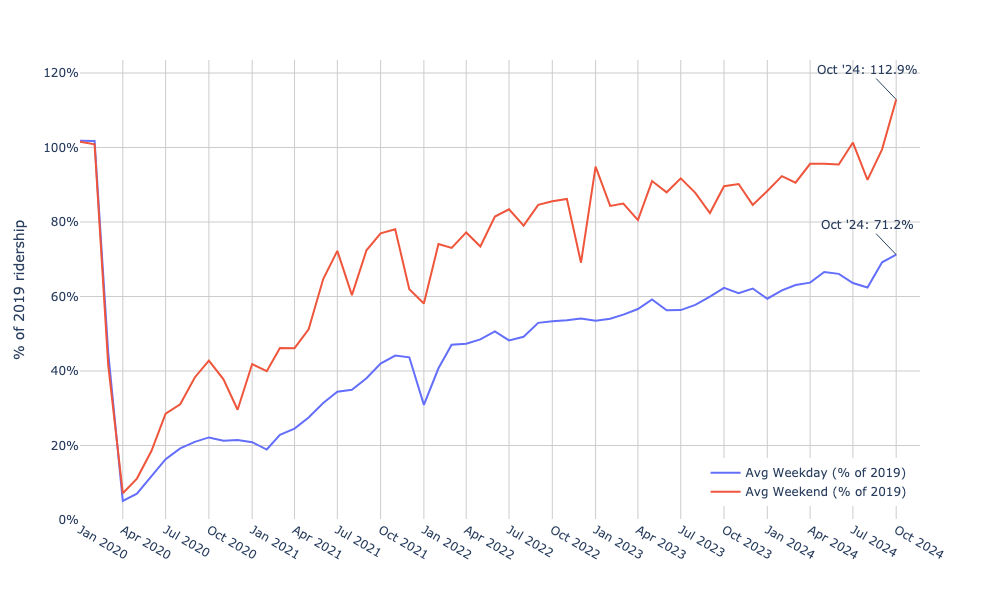

In [30]:
lines(
    cmp19[[f'{k} frac' for k in keys]].rename(columns={
        'avg weekday frac': 'Avg Weekday (% of 2019)',
        'avg weekend frac': 'Avg Weekend (% of 2019)',
    }),
    name='vs_2019',
    xname='% of 2019 ridership',
    xtick="M3",
    ytickformat=".0%",
    ann_offset=3,
    hovertemplate='%{y:.1%}',
    y_fmt='.1%',
    legend_lr=True,
)

# {Month,Station} data

In [31]:
export(df.set_index(['month', 'station']), 'path', fmts={'month': "%b '%y"}, per_page=20);

Saved parquet to .ire/path.parquet
